In [1]:
from typing import Sequence
import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tiktoken

# Model

### Layer Normalization

$y = \frac{x - E[x]}{\sqrt{E[(x - E[x])^2] + \epsilon}} \odot \gamma + \beta$

In [2]:
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape: Sequence[int], bias=True, eps=1e-5) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.ones(normalized_shape)) if bias else None
        self.eps = eps
    

    def forward(self, x: Tensor) -> Tensor: 
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, self.eps) 

### Self Attention

$[q_{i, j}, k_{i, j}, v_{i, j}] = x_{i, j}[W_q, W_k, W_v] + [b_q, b_k, b_v]$ 
where all $q, k, v, x, b$ are row vectors

$[q_{i, j}, k_{i, j}, v_{i, j}]$ are computed for $x_i$ in the 3D tensor 
$x = \begin{bmatrix}
x_{1, 1} & \dots & x_{1, T} \\
\vdots & \ddots & \vdots \\
x_{B, 1} & \dots & x_{B, T}
\end{bmatrix}$ resulting in tensors $q, k, v$

$x$ has shape $(B, T, C)$ where $B$ is the batch size, $T$ is the sequence length,
and $C$ is the number of embedding dimensions

$q, k, v$ have shape $(B, T, ND)$ where $B$ is the batch size, 
$T$ is the sequence length, $N$ is the number of attention heads, and $D$ is the
number of query/key dimensions

$q, k, v$ are reshaped to $(B, N, T, D)$

$a_{i, j} = q_{i, j} k_{i, j}^T$

$a_{i, j} = -\infty$ for all $i < j$

$a_{i, j} = \text{softmax}(a_{i, j})$ where softmax is computed rowwise

$y_{i, j} = a_{i, j} v_{i, j}$

$y$ has shape $(B, N, T, D)$

$y$ is reshaped to $(B, T, ND)$, so $y_{i, j}$ is a row vector

$y_{i, j} = y_{i, j}W_p + b_p$ 

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, n_embed: int, n_head: int, dropout: float, bias=True) -> None:
        super().__init__()
        self.n_embed = n_embed
        self.n_head = n_head
        assert n_embed % n_head == 0 
        self.D = n_embed // n_head

        self.c_attn = nn.Linear(n_embed, 3 * n_embed, bias=bias)
        self.c_proj = nn.Linear(n_embed, n_embed, bias=bias)

        self.dropout = dropout
        self.attn_dropout = nn.Dropout(dropout)
        self.res_dropout = nn.Dropout(dropout)

        self.attn_scale = 1.0 / np.sqrt(self.D)
    

    def forward(self, x: Tensor) -> Tensor:
        B, T, n_embed = x.shape
        assert n_embed == self.n_embed

        q, k, v = self.c_attn(x).split(self.n_embed, dim=2)

        q = q.view(B, T, self.n_head, self.D).transpose(1, 2) # gives shape (B, N, T, D)
        k = k.view(B, T, self.n_head, self.D).transpose(1, 2) # gives shape (B, N, T, D)
        v = v.view(B, T, self.n_head, self.D).transpose(1, 2) # gives shape (B, N, T, D)

        y = F.scaled_dot_product_attention(q, k, v, dropout_p=self.dropout, is_causal=True)
        y = y.transpose(1, 2).contiguous().view(B, T, self.n_embed) # concat head outputs 
        y = self.c_proj(y)
        y = self.res_dropout(y)
        return y

### MLP

$x_{i, j} = x_{i, j} W_{c} + B_{c}$

$y_{i, j} = x_{i, j} W_{p} + B_{p}$

In [4]:
class MLP(nn.Module):
    def __init__(self, n_embed: int, dropout: float, bias=True):
        super().__init__()
        self.c_fc = nn.Linear(n_embed, 4 * n_embed, bias=bias)
        self.c_proj = nn.Linear(4 * n_embed, n_embed, bias=bias)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x: Tensor) -> Tensor:
        x = F.gelu(self.c_fc(x))
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

### Block

Composition of layer normalization, self attention, and mlp

In [5]:
class Block(nn.Module):
    def __init__(self, n_embed: int, n_head: int, dropout: float, bias=True) -> None:
        super().__init__()
        self.ln_1 = LayerNorm(n_embed, bias=bias)
        self.attn = SelfAttention(n_embed, n_head, dropout, bias)
        self.ln_2 = LayerNorm(n_embed, bias=bias)
        self.mlp = MLP(n_embed, dropout, bias)


    def forward(self, x: Tensor) -> Tensor:
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

### Generative Transformer

- Input is an array of token indexes

- Computes token embeddings from the input

- Computes position embeddings from the sequence $[0, 1, ..., T - 1]$

- $x$ is the sum of the token and position embeddings

- $x$ is forwarded through all the blocks

- $x$ is layer normalized one more time

- $x$ is forwarded through a linear layer to transform it from the embedding dimension 
    to the vocab size

- If generating, $p = \text{softmax}(x)$, and the next index is drawn from the 
    distribution $p$

In [6]:
class GenerativeTransformer(nn.Module):
    def __init__(
        self, n_embed: int, n_head: int, block_size: int, 
        vocab_size: int, n_layer: int, dropout: float, bias=True,
    ) -> None:
        super().__init__()
        self.block_size = block_size

        args = (n_embed, n_head, dropout, bias)

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embed),
            wpe = nn.Embedding(block_size, n_embed),
            drop = nn.Dropout(dropout),
            h = nn.ModuleList([Block(*args) for _ in range(n_layer)]),
            ln_f = LayerNorm(n_embed, bias=bias),
        ))

        self.lm_head = nn.Linear(n_embed, vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight

        def init_weights(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02) 


        self.apply(init_weights)
    

    def forward(self, x_idx: Tensor) -> Tensor:
        device = x_idx.device
        _, T = x_idx.shape

        assert T <= self.block_size, \
            f"cannot forward sequence of length {T}, block size is only {self.block_size}"
        
        pos = torch.arange(0, T, dtype=torch.int64, device=device)

        tok_emb = self.transformer.wte(x_idx) # shape (B, T, C)
        pos_emb = self.transformer.wpe(pos) # shape (T, C)

        # (B, T, C) + (T, C) = (B, T, C)
        # elementwise addition for each batch
        x = self.transformer.drop(tok_emb + pos_emb)
        for blk in self.transformer.h:
            x = blk(x)
        x = self.transformer.ln_f(x)
        x = self.lm_head(x)
        return x
    

    @torch.no_grad()
    def generate(self, x_idx: Tensor, max_new_tokens: int, temperature=1.0) -> Tensor:
        # Take a conditioning sequence of indices x_idx (int64 tensor of shape (B, T)) and 
        # complete the sequence max_new_tokens times, feeding the predictions back into 
        # the model each time. Most likely you"ll want to make sure to be in model.eval() 
        # mode of operation for this.
        for _ in range(max_new_tokens):
            if x_idx.shape[1] <= self.block_size:
                x_idx_cropped = x_idx 
            else:
                x_idx_cropped = x_idx[:, -self.block_size:]

            logits = self(x_idx_cropped)
            logits = logits[:, -1, :] / temperature

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            x_idx = torch.cat((x_idx, idx_next), dim=1)

        return x_idx  

### GPT

Loads a pretrained model from Hugging Face

In [7]:
def GPT(model_type: str, override_args=None) -> GenerativeTransformer:
    assert model_type in {"gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"}
    override_args = override_args or {} # default to empty dict
    # only dropout can be overridden see more notes below
    assert all(k == "dropout" for k in override_args)
    from transformers import GPT2LMHeadModel
    print("loading weights from pretrained gpt: %s" % model_type)

    # n_layer, n_head and n_embed are determined from model_type
    config_args = {
        "gpt2":         dict(n_layer=12, n_head=12, n_embed=768),  # 124M params
        "gpt2-medium":  dict(n_layer=24, n_head=16, n_embed=1024), # 350M params
        "gpt2-large":   dict(n_layer=36, n_head=20, n_embed=1280), # 774M params
        "gpt2-xl":      dict(n_layer=48, n_head=25, n_embed=1600), # 1558M params
    }[model_type]
    
    print("forcing vocab_size=50257, block_size=1024, bias=True")
    config_args["vocab_size"] = 50257 # always 50257 for GPT model checkpoints
    config_args["block_size"] = 1024 # always 1024 for GPT model checkpoints
    config_args["bias"] = True # always True for GPT model checkpoints
    
    if "dropout" in override_args:
        print(f"overriding dropout rate to {override_args['dropout']}")
        config_args["dropout"] = override_args["dropout"]
    else:
        config_args["dropout"] = 0.0

    model = GenerativeTransformer(**config_args)
    sd = model.state_dict()
    sd_keys = sd.keys()
    # discard this mask / buffer, not a param
    sd_keys = [k for k in sd_keys if not k.endswith(".attn.bias")] 

    # init a huggingface/transformers model
    model_hf = GPT2LMHeadModel.from_pretrained(model_type)
    sd_hf = model_hf.state_dict()

    sd_keys_hf = sd_hf.keys()
    sd_keys_hf = [k for k in sd_keys_hf if not k.endswith(".attn.masked_bias")]
    sd_keys_hf = [k for k in sd_keys_hf if not k.endswith(".attn.bias")]
    transposed = [
        "attn.c_attn.weight", 
        "attn.c_proj.weight", 
        "mlp.c_fc.weight", 
        "mlp.c_proj.weight",
    ]

    assert len(sd_keys_hf) == len(sd_keys), \
        f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
    
    for k in sd_keys_hf:
        if any(k.endswith(w) for w in transposed):
            assert sd_hf[k].shape[::-1] == sd[k].shape
            with torch.no_grad():
                sd[k].copy_(sd_hf[k].T)
        else:
            assert sd_hf[k].shape == sd[k].shape
            with torch.no_grad():
                sd[k].copy_(sd_hf[k])

    return model

# Training

In [2]:
OUT_DIR = "out"
EVAL_INTERVAL = 1000
LOG_INTERVAL = 1

DATA_DIR = "../data"

BATCH_SIZE = 3
BLOCK_SIZE = 1024

DEVICE = "mps"
DTYPE = torch.bfloat16

START_LR = 1e-3
WARMUP_ITERS = 2000
LR_DECAY_ITERS = 600000
MIN_LR = 1e-4

Load data as blocks

$x_i = [d_i, d_{i + 1}, ..., d_{i + b}]$

$y_i = [d_{i + 1}, d_{i + 2}, ..., d_{i + b + 1}]$

In [9]:
def get_batch(split: str) -> tuple[Tensor, Tensor]:
    if split == "train":
        data = np.memmap(os.path.join(DATA_DIR, "train.bin"), dtype=np.uint16, mode="r")
    else:
        data = np.memmap(os.path.join(DATA_DIR, "val.bin"), dtype=np.uint16, mode="r")

    def make_block(i: int) -> Tensor:
        return torch.from_numpy(data[i:i + BLOCK_SIZE].astype(np.int64))
    

    idxs = torch.randint(len(data) - BLOCK_SIZE, (BATCH_SIZE,))
    x = torch.stack([make_block(i) for i in idxs]).to(DEVICE)
    y = torch.stack([make_block(i + 1) for i in idxs]).to(DEVICE)
    return x, y

$\eta_i = \begin{cases}
    \frac{\eta \cdot i}{N_{\text{warmup}}} & i < N_{\text{warmup}} \\
    \eta_{\text{min}} + \left(
        \frac{1}{2} + \frac{1}{2}\cos\left(
            \pi \frac{N_{\text{warmup}} \cdot i}{N_{\text{decay}} - N_{\text{warmup}}}
        \right)
    \right)(\eta_0 - \eta_{\text{min}}) & N_{\text{warmup}} \leq i < N_{\text{decay}} \\
    \eta_{\text{min}} & N_{\text{decay}} \leq i
\end{cases}$

In [3]:
def get_lr(iter_num: int) -> float:
    if iter_num < WARMUP_ITERS: 
        return START_LR * iter_num / WARMUP_ITERS 
    
    if iter_num > LR_DECAY_ITERS:
        return MIN_LR
    
    decay_ratio = (iter_num - WARMUP_ITERS) / (LR_DECAY_ITERS - WARMUP_ITERS)
    assert 0 <= decay_ratio and decay_ratio <= 1
    coeff = 0.5 * (1.0 + np.cos(np.pi * decay_ratio))
    return MIN_LR + coeff * (START_LR - MIN_LR)

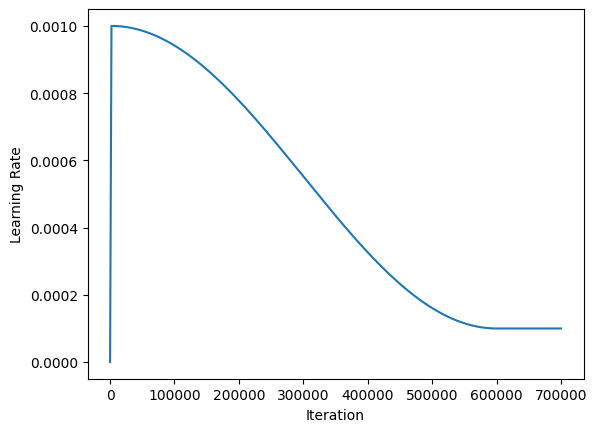

In [4]:
plt.plot([get_lr(i) for i in range(1, LR_DECAY_ITERS + 100001)])
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.show()

- Any parameters that is 2D will be weight decayed

- No weight tensors in matmuls and embeddings have weight decay

- Biases and layernorms don't have weight decay

In [ ]:
def configure_optimizer(
    params: Sequence[nn.Parameter], lr: float, 
    betas: tuple[float, float], weight_decay: float,
) -> optim.Adam:
    grad_params = [p for p in params if p.requires_grad]
    decay_params = [p for p in grad_params if p.dim() >= 2]
    nodecay_params = [p for p in grad_params if p.dim() < 2]
    optim_groups = [
        {"params": decay_params, "weight_decay": weight_decay},
        {"params": nodecay_params, "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=lr, betas=betas)
    return optimizer

Initialize model and optimizer

In [ ]:
model = GenerativeTransformer(
    n_embed=768, 
    n_head=12, 
    block_size=BLOCK_SIZE, 
    vocab_size=50304, # 50257 for gpt2
    n_layer=12, 
    dropout=0.0, 
    bias=True,
).to(device=DEVICE, dtype=DTYPE)

In [ ]:
optimizer = configure_optimizer(
    model.parameters(), 
    lr=START_LR, 
    betas=(0.9, 0.95), 
    weight_decay=0.1,
)

Load state from checkpoint

In [ ]:
# checkpoint = torch.load("{OUT_DIR}/checkpoint.pt")
# model.load_state_dict(checkpoint["model"])
# optimizer.load_state_dict(checkpoint["optimizer"])

Estimate loss for training and validation splits

In [ ]:
@torch.no_grad()
def evaluate_loss(n_iters=50) -> dict[str, float]:
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(n_iters)
        for k in range(n_iters):
            x, y = get_batch(split)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

Estimate loss, and save checkpoint if validation loss is improved

In [ ]:
def eval_and_save_checkpoint(iter_num: int) -> None:
    losses = evaluate_loss()
    print(f"train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    if losses["val"] < best_val_loss:
        best_val_loss = losses["val"]
        if iter_num > 0:
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "iter_num": iter_num,
                "best_val_loss": best_val_loss,
            }
            torch.save(checkpoint, os.path.join(OUT_DIR, "checkpoint.pt"))
            print(f"saved checkpoint to {OUT_DIR}")

### Crossentropy loss:

$l(x, y, \theta) = -\sum_i y_i \log(f(x_i, \theta))$

<br>

### Train Step with Adam Optimizer

$g_t = \nabla_{\theta_{t - 1}} l(x, y, )$

$\alpha = \eta \frac{\sqrt{1 - \beta_2^t}}{1 - \beta_1^t}$

$m_t = \beta_1 m_{t - 1} + (1 - \beta_1)g_t$

$m_t = \beta_2 v_{t - 1} + (1 - \beta_2)g_t^2$

$\theta_t = \theta_{t - 1} - \alpha \frac{m_t}{\sqrt{v_t} + \epsilon}$

In [ ]:
iter_num = 1
best_val_loss = 1e9
t0 = time.time()

while True:
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    
    x, y = get_batch("train")

    logits = model(x)
    loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)

    if iter_num % LOG_INTERVAL == 0:
        t1 = time.time()
        dt = t1 - t0
        t0 = t1
        print(f"iter {iter_num}: loss {loss.item():.4f}, time {dt:.2f}s")

    if iter_num % EVAL_INTERVAL == 0:
        eval_and_save_checkpoint(iter_num)

    iter_num += 1

# Prompt

In [ ]:
model = GPT("gpt2").to(DEVICE)

In [ ]:
encoder = tiktoken.get_encoding("gpt2")

In [ ]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens=500, temperature=1.0) -> str:
    encoded = encoder.encode(prompt)
    x = torch.tensor(encoded, dtype=torch.int64, device=DEVICE)[None, :]
    y = model.generate(x, max_new_tokens, temperature)
    decoded = encoder.decode(y[0].tolist())
    return decoded

In [ ]:
prompt = "I like to play violin, I play in a"

In [ ]:
generate(prompt, max_new_tokens=10)